In [336]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter

In [337]:
#Load data
file_path = 'C:\\Users\\paulb\\PycharmProjects\\PBL_BI_LSTM\\.venv\\RandomForest Datenset 1.csv'
data = pd.read_csv(file_path, sep='\t')
data.head()

,Sequence,Charge,Mass,Length,CCS,NumRotatableBonds,NumConformers,NumAtoms,FractionSP3
0,AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...,4,4401.106890,52,2.654046e-35,134.0,0.0,309.0,0.668508
1,AAAAAAAAAK,1,785.439552,10,5.981752e-36,23.0,0.0,55.0,0.696970
2,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,2367.203020,29,1.208337e-35,64.0,0.0,166.0,0.696970
3,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,2367.203020,29,2.200959e-35,64.0,0.0,166.0,0.696970
4,AAAAAAAK,1,643.365324,8,6.811654e-36,19.0,0.0,45.0,0.703704


In [338]:
sequences = data['Sequence'].values
charge = data['Charge'].values
ccs = data['CCS'].values

In [339]:
# Define the 20 standard amino acids
amino_acids = 'ACDEFGHIKLMNPQRSTVWYU'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

def one_hot_encode(seq, max_length):
    padded_seq = seq.ljust(max_length, 'X')
    int_encoded = [aa_to_int.get(aa, len(amino_acids)) for aa in padded_seq]  # Use a default index for unknown amino acids
    one_hot_encoded = np.zeros((max_length, len(amino_acids) + 1))  # +1 for the unknown amino acid
    for i, value in enumerate(int_encoded):
        one_hot_encoded[i, value] = 1
    return one_hot_encoded.flatten()

In [340]:
# Determine the maximum sequence length
max_seq_length = max(data['Sequence'].apply(len))

# Encode the sequences
one_hot_encoded_sequences = np.array([one_hot_encode(seq, max_seq_length) for seq in data['Sequence']])

# Initialize the label encoder for charge states
label_encoder = LabelEncoder()
encoded_charge_states = label_encoder.fit_transform(data['Charge'].tolist())

normalized_ccs_values = (ccs - ccs.min()) / (ccs.max() - ccs.min())

In [341]:

encoded_features = np.hstack((
    one_hot_encoded_sequences,
    encoded_charge_states.reshape(-1, 1),
    
))

In [343]:
class AminoAcidDataset(Dataset):
    def __init__(self, sequences, encoded_features, ccs):
        self.sequences = sequences
        self.encoded_features = encoded_features
        self.ccs = ccs

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx].reshape(max_seq_length, -1), dtype=torch.float32)
        encoded_feature = torch.tensor(self.encoded_features[idx], dtype=torch.float32)
        ccs = torch.tensor(self.ccs[idx], dtype=torch.float32)

        return sequence, encoded_feature, ccs




In [344]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, additional_features_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        dropout = 0 if num_layers==1 else dropout_rate
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc1 = nn.Linear(hidden_size + additional_features_size, 64)
        self.fc2 = nn.Linear(64, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, sequence, features):
        batch_size = sequence.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(sequence.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(sequence.device)

        out, _ = self.lstm(sequence, (h0, c0))
        out= self.dropout(out)
        lstm_output = out[:, -1, :]
        combined = torch.cat((lstm_output, features), dim=1)

        out = self.fc1(combined)
        out = self.fc2(out)

        return out




In [345]:
# Hyperparameters
input_size = len(amino_acids) + 1  
hidden_size = 50
num_layers = 2
output_size = 1
additional_features_size = encoded_features.shape[1]  
learning_rate = 0.001
batch_size = 32
num_epochs = 10
dropout_rate = 0.22

# Initializing model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size, additional_features_size, dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=2,gamma=0.1)


# Move model to GPU 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


LSTMModel(
  (lstm): LSTM(22, 50, num_layers=2, batch_first=True, dropout=0.22)
  (fc1): Linear(in_features=1195, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.22, inplace=False)
)

In [346]:
indices = np.arange(len(dataset))

# Shuffle indices to randomize
np.random.shuffle(indices)

# Calculate sizes
train_size = int(0.7 * len(indices))
val_size = int(0.2 * len(indices))
test_size = len(indices) - train_size - val_size

# Split indices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [347]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [348]:
train_set = set(train_indices)
val_set = set(val_indices)
test_set = set(test_indices)

assert train_set.isdisjoint(val_set), "Train and Validation sets overlap!"
assert train_set.isdisjoint(test_set), "Train and Test sets overlap!"
assert val_set.isdisjoint(test_set), "Validation and Test sets overlap!"

In [349]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=3, verbose=True)


In [351]:
import optuna
def objective(trial):
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 8, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Initialize the model
    model = LSTMModel(
        input_size, hidden_size, num_layers, output_size, additional_features_size, dropout_rate
    ).to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 5
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for sequences, features, ccs in train_loader:
            sequences, features, ccs = sequences.to(device), features.to(device), ccs.to(device)

            outputs = model(sequences, features)
            outputs, ccs = outputs.view(-1), ccs.view(-1)  # Flatten tensors

            loss = criterion(outputs, ccs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)

    # Evaluation loop
    model.eval()
    running_eval_loss = 0.0
    predictions = []
    true_values = []
    with torch.no_grad():
        for sequences, features, ccs in test_loader:
            sequences, features, ccs = sequences.to(device), features.to(device), ccs.to(device)

            outputs = model(sequences, features)
            outputs, ccs = outputs.view(-1), ccs.view(-1)

            loss = criterion(outputs, ccs)
            running_eval_loss += loss.item()

            predictions.extend(outputs.cpu().numpy().flatten())
            true_values.extend(ccs.cpu().numpy().flatten())

    avg_eval_loss = running_eval_loss / len(test_loader)
    mae = mean_absolute_error(true_values, predictions)
    

    return mae

# Create and optimize study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=150)

# Print best trial
print("Best trial:")
print(f" Value (MAE): {study.best_trial.value}")
print(" Params:")
for key, value in study.best_trial.params.items():
    print(f"   {key}: {value}")

# Print worst trial
worst_trial = sorted(study.trials, key=lambda t: t.value, reverse=True)[0]
print("\nWorst trial:")
print(f" Value (MAE): {worst_trial.value}")
print(" Params:")
for key, value in worst_trial.params.items():
    print(f"   {key}: {value}")


'import optuna\ndef objective(trial):\n    # Suggest hyperparameters\n    hidden_size = trial.suggest_int(\'hidden_size\', 8, 128)\n    num_layers = trial.suggest_int(\'num_layers\', 1, 3)\n    dropout_rate = trial.suggest_float(\'dropout_rate\', 0.1, 0.4)\n    learning_rate = trial.suggest_float(\'learning_rate\', 1e-5, 1e-2, log=True)\n\n    # Initialize the model\n    model = LSTMModel(\n        input_size, hidden_size, num_layers, output_size, additional_features_size, dropout_rate\n    ).to(device)\n    criterion = nn.L1Loss()\n    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)\n\n    num_epochs = 5\n    # Training loop\n    for epoch in range(num_epochs):\n        model.train()\n        running_train_loss = 0.0\n        for sequences, features, ccs in train_loader:\n            sequences, features, ccs = sequences.to(device), features.to(device), ccs.to(device)\n\n            outputs = model(sequences, features)\n            outputs, ccs = outputs.view(-1), cc

In [352]:
# Training phase
train_losses = []
eval_losses = []
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for sequences, features, ccs in train_loader:
        sequences = sequences.to(device)
        features = features.to(device)
        ccs = ccs.to(device)
        
        outputs = model(sequences, features)
        
        # Ensure outputs and ccs are 1D and have the same shape
        outputs = outputs.view(-1)  # Flatten outputs
        ccs = ccs.view(-1)  # Flatten ccs
        
        loss = criterion(outputs, ccs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():  
        for sequences, features, ccs in val_loader:
            sequences = sequences.to(device)
            features = features.to(device)
            ccs = ccs.to(device)
            
            outputs = model(sequences, features)
            
            # Ensure outputs and ccs are 1D and have the same shape
            outputs = outputs.view(-1)
            ccs = ccs.view(-1)
            
            loss = criterion(outputs, ccs)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    eval_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    scheduler.step()
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Training stopped")
        break


Epoch [1/10], Train Loss: 0.0019, Val Loss: 0.0011
Epoch [2/10], Train Loss: 0.0009, Val Loss: 0.0009
Epoch [3/10], Train Loss: 0.0006, Val Loss: 0.0006
Epoch [4/10], Train Loss: 0.0006, Val Loss: 0.0006
Epoch [5/10], Train Loss: 0.0006, Val Loss: 0.0006
Epoch [6/10], Train Loss: 0.0006, Val Loss: 0.0006
EarlyStopping counter: 1/3
Epoch [7/10], Train Loss: 0.0006, Val Loss: 0.0006
Epoch [8/10], Train Loss: 0.0006, Val Loss: 0.0006
Epoch [9/10], Train Loss: 0.0006, Val Loss: 0.0006
EarlyStopping counter: 1/3
Epoch [10/10], Train Loss: 0.0006, Val Loss: 0.0006
EarlyStopping counter: 2/3


In [353]:
# Testing phase
model.eval()
running_test_loss = 0.0
with torch.no_grad():  # Disable gradient calculation for testing
    for sequences, features, ccs in test_loader:
        sequences = sequences.to(device)
        features = features.to(device)
        ccs = ccs.to(device)

        outputs = model(sequences, features)

        # Ensure outputs and ccs are 1D and have the same shape
        outputs = outputs.view(-1)
        ccs = ccs.view(-1)

        loss = criterion(outputs, ccs)
        running_test_loss += loss.item()

avg_test_loss = running_test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 0.0006


In [354]:
mse = mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

print(f"Predictions length: {len(predictions)}")
print(f"True values length: {len(true_values)}")

Mean Squared Error (MSE): 0.0007
R² Score: 0.9822
Predictions length: 43236
True values length: 43236


In [355]:
"""from plotnine import ggplot, aes, geom_point, labs, theme, element_text
import pandas as pd

# Extract the Charge values for the test set
test_charge_values = data.iloc[test_dataset.indices]['Charge'].values

# Ensure that Charge values, predictions, and true values are all of the same length
df = pd.DataFrame({
    'Charge': test_charge_values,  # Use Charge values corresponding to the test set
    'CCS_pred': predictions,       # Predicted CCS
    'CCS_actual': true_values      # Actual CCS
})

# Create the plot
plot = (
    ggplot(df, aes(x='CCS_pred', y='CCS_actual', color='Charge'))  # Map Charge to color
    + geom_point()  # Scatter plot
    + labs(
        y="Actual CCS",
        x="Predicted CCS",
        title="Actual vs. Predicted CCS"
    )
    + theme(
        plot_title=element_text(size=18),         # Title font size
        axis_title_x=element_text(size=18),       # X-axis title font size
        axis_title_y=element_text(size=18),       # Y-axis title font size
        legend_title=element_text(size=18),       # Legend title font size
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14),        # Y-axis tick label font size
        legend_text=element_text(size=14)         # Legend text font size
    )
)

# Display the plot
plot
plot.save("actual_vs_predicted_ccs.png", width=8, height=6, dpi=300)"""

'from plotnine import ggplot, aes, geom_point, labs, theme, element_text\nimport pandas as pd\n\n# Extract the Charge values for the test set\ntest_charge_values = data.iloc[test_dataset.indices][\'Charge\'].values\n\n# Ensure that Charge values, predictions, and true values are all of the same length\ndf = pd.DataFrame({\n    \'Charge\': test_charge_values,  # Use Charge values corresponding to the test set\n    \'CCS_pred\': predictions,       # Predicted CCS\n    \'CCS_actual\': true_values      # Actual CCS\n})\n\n# Create the plot\nplot = (\n    ggplot(df, aes(x=\'CCS_pred\', y=\'CCS_actual\', color=\'Charge\'))  # Map Charge to color\n    + geom_point()  # Scatter plot\n    + labs(\n        y="Actual CCS",\n        x="Predicted CCS",\n        title="Actual vs. Predicted CCS"\n    )\n    + theme(\n        plot_title=element_text(size=18),         # Title font size\n        axis_title_x=element_text(size=18),       # X-axis title font size\n        axis_title_y=element_text(size=18

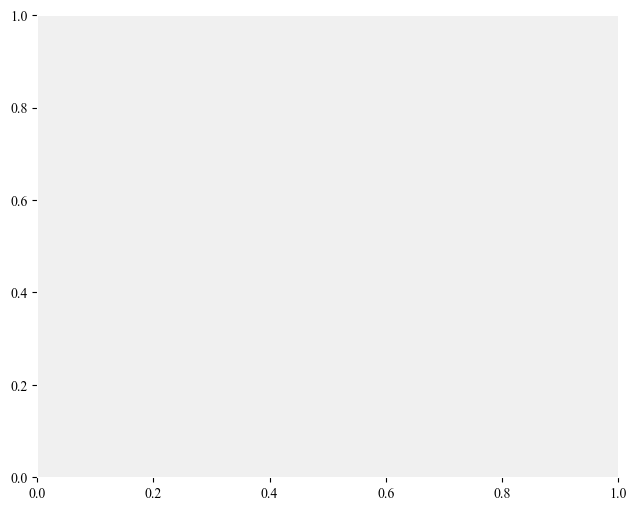

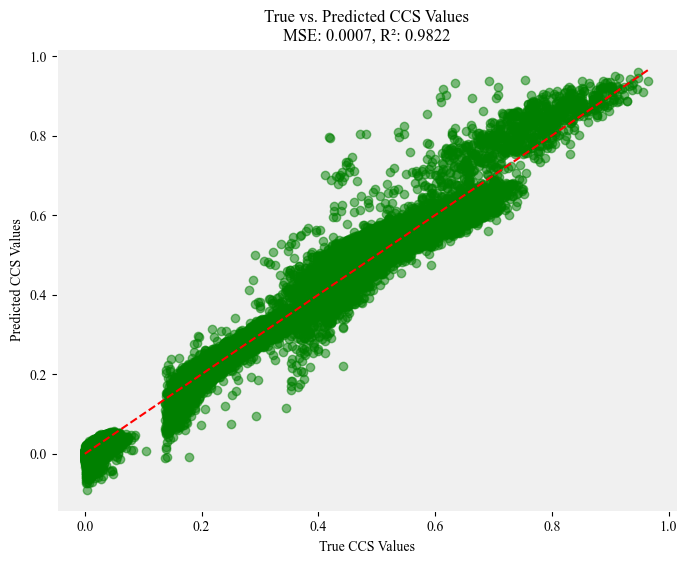

In [356]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(true_values, predictions, color='green', alpha=0.5)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--')
plt.xlabel('True CCS Values')
plt.ylabel('Predicted CCS Values')
plt.title(f'True vs. Predicted CCS Values\nMSE: {mse:.4f}, R²: {r2:.4f}')
plt.show()



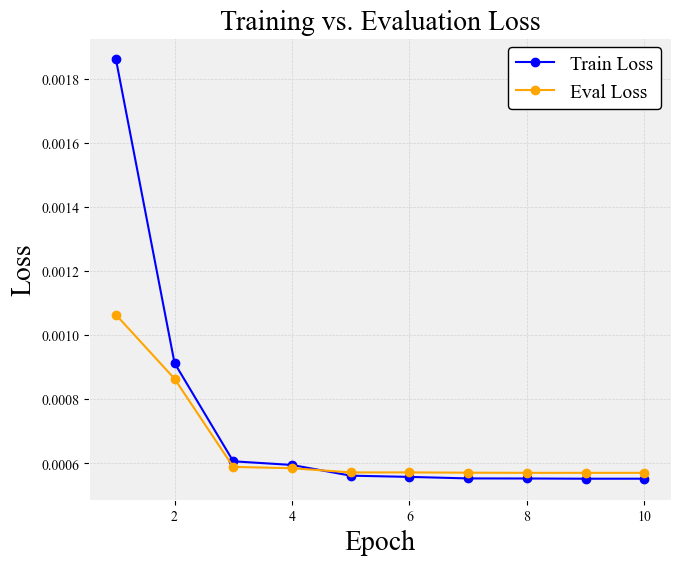

In [357]:
import matplotlib.pyplot as plt

# Set global style parameters
plt.rcParams['axes.facecolor'] = '#f0f0f0'  # Axes background
plt.rcParams['figure.facecolor'] = 'white'  # Figure background
plt.rcParams['axes.edgecolor'] = 'white'  # Border color
plt.rcParams['axes.labelcolor'] = 'black'  # Label color
plt.rcParams['xtick.color'] = 'black'  # X-axis tick color
plt.rcParams['ytick.color'] = 'black'  # Y-axis tick color
plt.rcParams['text.color'] = 'black'  # General text color
plt.rcParams['legend.frameon'] = True  # Enable legend frame
plt.rcParams['legend.framealpha'] = 1  # Legend frame opacity
plt.rcParams['legend.facecolor'] = 'white'  # Legend background color
plt.rcParams['legend.edgecolor'] = 'black'# Legend border color
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman']})

# Plotting the loss curves
plt.figure(figsize=(7.5, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), eval_losses, label='Eval Loss', color='orange', marker='o')

# Customizing labels, title, and grid
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Training vs. Evaluation Loss', fontsize=20)
plt.legend(fontsize=14)
plt.grid(True, color='lightgray', linestyle='--', linewidth=0.5)


plt.savefig("loss2.png", format="png", dpi=300)
# Show the plot
plt.show()


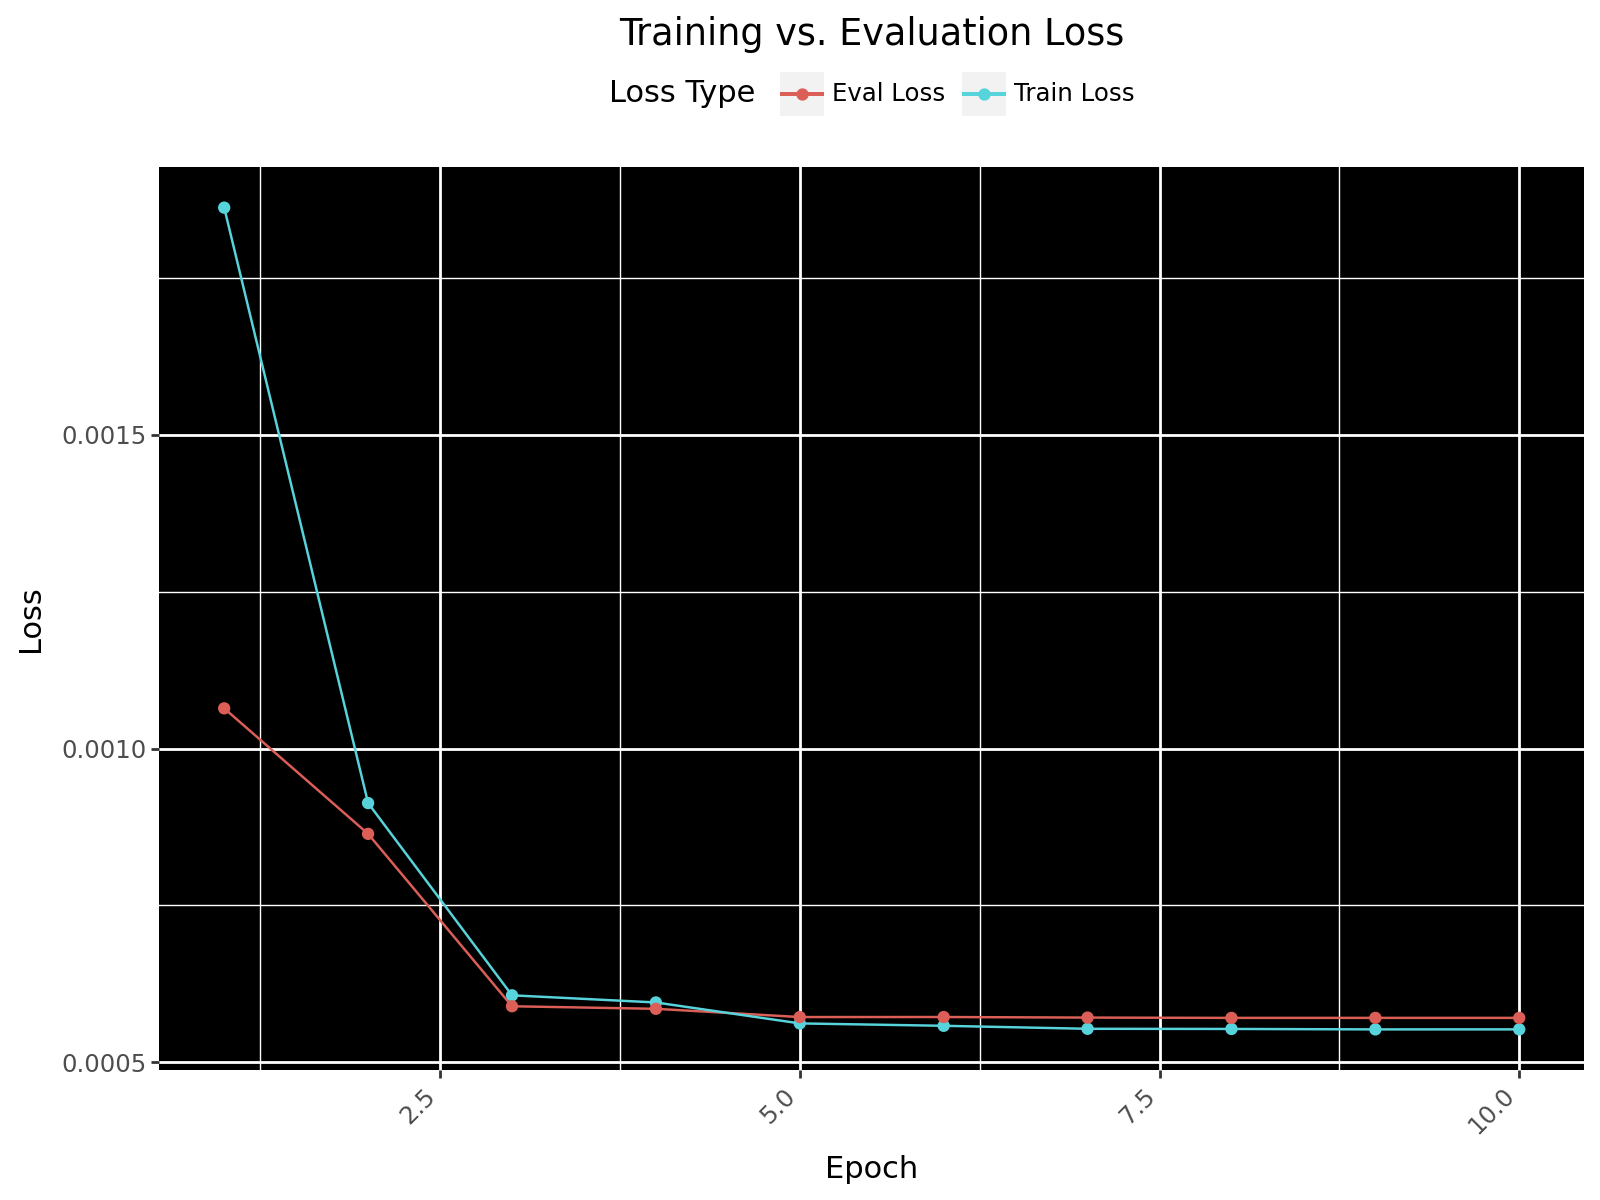

In [358]:
"""import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme, element_text
# Assuming 'train_losses' and 'eval_losses' are lists of loss values, and 'num_epochs' is the total number of epochs
data = pd.DataFrame({
    'Epoch': list(range(1, num_epochs + 1)),
    'Train Loss': train_losses,
    'Eval Loss': eval_losses
})

# Reshape the data to have one column for loss and another for the type (Train or Eval)
data_melted = data.melt(id_vars=['Epoch'], value_vars=['Train Loss', 'Eval Loss'], 
                        var_name='Loss Type', value_name='Loss')

# Create the plot with plotnine
plot = (ggplot(data_melted, aes(x='Epoch', y='Loss', color='Loss Type'))
        + geom_line()
        + geom_point()
        + labs(title='Training vs. Evaluation Loss', x='Epoch', y='Loss')
        + theme(axis_text_x=element_text(rotation=45, hjust=1), 
                figure_size=(8, 6), 
                panel_background=element_text(color='black'), 
                legend_position='top'))

plot"""